### 1. Read and explore the data

#### 1.1 Import Python module

In [1]:
import gc
import time
import os
import cv2
import shutil
import random
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
from torch import optim
from sklearn.metrics import *
from sklearn.model_selection import KFold

seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

num_workers = 4
batch_size = 10
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
categories = ['COVID19', 'NORMAL', 'PNEUMONIA']
num_classes = len(categories)
splits = ['train', 'val', 'test']
DATA_PATH = r"C:\Gunther\Datasets\Covid19DLH_80_10_10\Data"
model_path = r"C:\Gunther\OneDrive - University of Illinois - Urbana\Python\DLH\Project"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'You are using {device}')

def show_dataset(data_path=DATA_PATH):
    df = pd.DataFrame(columns = ['code'] + splits, index = categories)
    for row in categories:
        for col in splits:
            df.loc[row,col] = int(len(os.listdir(os.path.join(data_path, col+'/'+row))))
    df['total'] = df.sum(axis=1).astype(int)
    df.loc['TOTAL'] = df.sum(axis=0).astype(int)
    df['code'] = ['0', '1', '2','']
    print(df)
    return df

df_dataset = show_dataset()

def load_data(data_path=DATA_PATH, num_workers=num_workers):
    transform = transforms.Compose([transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                   ])
    train_data = datasets.ImageFolder(root=data_path + '/train', transform=transform)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_data = datasets.ImageFolder(root=data_path + '/val', transform=transform)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_data = datasets.ImageFolder(root=data_path + '/test', transform=transform)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_data, train_loader, val_data, val_loader, test_data, test_loader

train_data, train_loader, val_data, val_loader, test_data, test_loader = load_data()
dataset = torch.utils.data.ConcatDataset([train_data, val_data, test_data])

def calc_metrics(predictions, actuals, row):
    df = pd.DataFrame(columns =metrics)
    Y_pred = np.concatenate(predictions, axis=0)
    Y_test = np.concatenate(actuals, axis=0)
    df.loc[row, 'Accuracy'] = accuracy_score(Y_test, Y_pred)
    df.loc[row, 'Precision'] = precision_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'Recall'] = recall_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'F1-score'] = f1_score(Y_test, Y_pred, average="macro")
    return df

def create_confusion_matrix(preds, y_test):
    ylist, predlist = [], []
    for pred in preds:
        for item in pred:
            predlist.append(int(item))
    for y in y_test:
        for item in y:
            ylist.append(int(item))
    data_dict = {'y_Actual':    ylist, 'y_Predicted': predlist}
    df = pd.DataFrame(data_dict, columns=['y_Actual','y_Predicted'])
    cm = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['ACTUAL'], colnames=['PREDICTED'])
    return cm

def train_val_model(model):
    t_start = time.time()
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'train', 'val', 'test acc'])
    print(f"Training model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and {n_epochs} epochs, and validating with {df_dataset.loc['TOTAL', 'val']} samples\n")
    train_size, val_size = len(train_loader), len(val_loader)
    for epoch in range(1, n_epochs+1):
        # Beginning of training step
        t0 = time.time()
        model.train()
        train_loss, val_loss = 0.0, 0.0
        for i, (data, target) in enumerate(train_loader):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().numpy()
        # Beginning of evaluation step
        model.eval()
        for j, (data, target) in enumerate(val_loader):
            target = target.to(device)
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.detach().cpu().numpy()
        predictions, actuals = calc_pred_actuals(model, test_loader)
        df_test = calc_metrics(predictions, actuals, 'Test accuracy').astype(float)
        print(f"Epoch {epoch}:\t train loss={train_loss/train_size:.5f} \t val loss={val_loss/val_size:.5f} \t test acc={df_test.iloc[0,0]:.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, train_loss/train_size, val_loss/val_size, df_test.iloc[0,0]]
        if use_scheduler: scheduler.step(val_loss/val_size)   # Optional to use scheduler for dynamic learning rate
    print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
    return model, df

def calc_pred_actuals(model, loader):
    predictions, actuals = [], []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            Y_pred_orig = model(data)
            _, Y_pred_tag = torch.max(Y_pred_orig, dim = 1)
            Y_pred_tag = Y_pred_tag.detach().cpu().numpy()
            Y_pred_tag = Y_pred_tag.reshape(len(Y_pred_tag), 1).astype('int8')
            Y_test = target.detach().cpu().numpy()
            Y_test = Y_test.reshape(len(Y_test), 1).astype('int8')
            predictions.append(Y_pred_tag)
            actuals.append(Y_test)
    return predictions, actuals

def test_model(model):
    model.eval()
    print(f"Testing the model {model_name} with {df_dataset.loc['TOTAL', 'test']} samples \n")   
    predictions, actuals = calc_pred_actuals(model, test_loader)
    conf_matrix = create_confusion_matrix(predictions, actuals)
    df_test = calc_metrics(predictions, actuals, 'Test Results').astype(float)
    print(df_test)
    return df_test, conf_matrix

def plot_train_val_losses(df):
    df2 = pd.melt(df, id_vars=['epoch'], value_vars=['train', 'val'], var_name='process', value_name='loss')
    sns.lineplot(x = "epoch", y = "loss", data = df2, hue = "process",
                style = "process", palette = "hot", dashes = False, 
                markers = ["o", "<"],  legend="brief").set_title("Train and Validation Losses by Epoch")
    plt.show()

You are using cuda
          code train  val test  total
COVID19      0   460   58   58    576
NORMAL       1  1266  158  159   1583
PNEUMONIA    2  3418  427  428   4273
TOTAL           5144  643  645   6432


In [2]:
w = [128, 128, 256, 256]

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, w[0], 3, padding=1)
        self.bn1 = nn.BatchNorm2d(w[0])
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv2 = nn.Conv2d(w[0], w[1], 3, padding=1)
        self.bn2 = nn.BatchNorm2d(w[1])
        self.conv3 = nn.Conv2d(w[1], w[2], 3, padding=1)
        self.bn3 = nn.BatchNorm2d(w[2])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear1 = nn.Linear(14 * 14 * w[2], w[3])
        self.linear2 = nn.Linear(w[3], 3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool2(self.relu(self.bn3(self.conv3(x))))
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [3]:
test = False

seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
net = Net().to(device)
model_name = 'DLH_team'
n_epochs = 100
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)


use_scheduler = False   # Set True if using scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2, threshold = 0.001, verbose=True, min_lr = 1e-5, threshold_mode = 'abs')
our_model, df_epochs = train_val_model(net)

Training model DLH_team with 5144 samples and 100 epochs, and validating with 643 samples

Epoch 1:	 train loss=0.34874 	 val loss=0.16678 	 test acc=0.94264 	 time=95.46s
Epoch 2:	 train loss=0.20170 	 val loss=0.14297 	 test acc=0.95659 	 time=94.76s
Epoch 3:	 train loss=0.16935 	 val loss=0.15792 	 test acc=0.94729 	 time=95.35s
Epoch 4:	 train loss=0.15661 	 val loss=0.14228 	 test acc=0.94729 	 time=95.19s
Epoch 5:	 train loss=0.14096 	 val loss=0.12323 	 test acc=0.95349 	 time=98.11s
Epoch 6:	 train loss=0.12372 	 val loss=0.12225 	 test acc=0.95349 	 time=96.30s
Epoch 7:	 train loss=0.11439 	 val loss=0.12023 	 test acc=0.95349 	 time=95.85s
Epoch 8:	 train loss=0.11156 	 val loss=0.19400 	 test acc=0.93643 	 time=95.41s
Epoch 9:	 train loss=0.10401 	 val loss=0.13085 	 test acc=0.95969 	 time=95.15s
Epoch 10:	 train loss=0.09431 	 val loss=0.13129 	 test acc=0.94884 	 time=96.30s
Epoch 11:	 train loss=0.09116 	 val loss=0.11182 	 test acc=0.95814 	 time=96.03s
Epoch 12:	 train

In [6]:
torch.save(our_model.state_dict(), os.path.join(model_path, 'best5.pth'))

#### 6.1 Plot epoch train and validation losses of the model

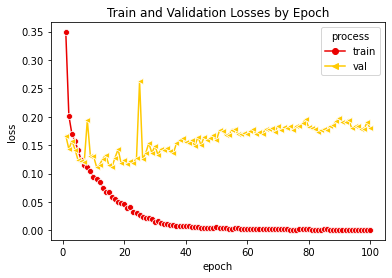

In [5]:
plot_train_val_losses(df_epochs)

#### 6.2 Test our own model

In [7]:
test_results, conf_matrix_test = test_model(our_model)

Testing the model DLH_team with 645 samples 

              Accuracy  Precision    Recall  F1-score
Test Results  0.967442   0.965444  0.956881   0.96106


#### 6.3 Show confusion matrix for test dataset

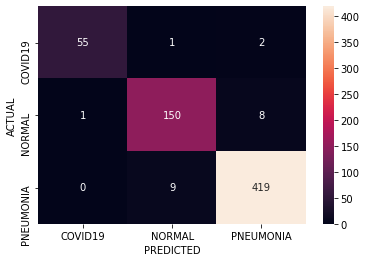

In [9]:
_ = sns.heatmap(conf_matrix_test, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)